# Modeling Crop Yield
## Python modules

In [3]:
import warnings
import time
import os

import dask
from dask.distributed import Client

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import geopandas

import pyarrow
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from scipy.stats import spearmanr
from scipy.linalg import LinAlgWarning
from scipy.stats import pearsonr

import math
import seaborn as sns

## Parameters
#### Choose a satellite.

For a description of the Landsat 8 mission, see the US Geological metadata [here.]()

For a description of the Sentinel 2 mission, see the US Geological metadata [here.]()

In [4]:
#satellite = "landsat-8-c2-l2"
satellite = "sentinel-2-l2a"

#### Choose band combination.

For a description of **Landsat** bands, see the [US Geological Survey documentation here.](https://www.usgs.gov/faqs/what-are-band-designations-landsat-satellites)

For a description of **Sentinel bands**, see the [US Geological Survey documentation here.](https://www.usgs.gov/centers/eros/science/usgs-eros-archive-sentinel-2#:~:text=4%20bands%20at%2010%20meter,%2Dinfrared%20(842%20nm)

According to our results, bands **(insert band selection here)** result in the best model performance for Landsat, and **(insert band selection here)** result in the best model performance for Sentinel for the task of predicting agricultural outcomes in Zambia.

In [5]:
# bands = "2-3-4"
# bands = "2-3-4-8"
# bands = "1-2-3-4-5-6-7"
# bands = "2-3-4-5-6-7-8-11-12"
bands = "3-4-5"

#### Choose the number of points that were featurized.

Each value in the following chunk represents the amount of thousands of points that were featurized in each respective feature file. These points represent a uniform subset of the spatial grid of Zambia. Points are spaced at uniform intervals for each selection, measured in kilometers in the longitudinal direction for each set of features. The kilometer distance interval differs for each selection below; 42,000 points results in the smallest uniform distance between points, and 4,000 points results in the greatest uniform distance between points. Selecting a greater quantity of points results in a denser spatial sample, which increases computational cost and time, but increases the spatial resolution of the model. Regardless of the quantity of points selected, each point is buffered by the same distance, resulting in a 1km^2 cell around each point.

These specific options point quantities is a result of uniformly increasing the distance between points in units of kilometers prior to matching satellite images to each point. These options represent the number of points that fall within the borders of Zambia, and the numbers have been rounded to the nearest thousandth for consistency in naming files. See the [CropMOSAIKS Featurization repository](https://github.com/cropmosaiks/Featurization) for more information regarding how these distances we calculated. 

In [6]:
#points = 15
#points = 20
points = 22

#### Choose which months to use in the model.

Note that months 10, 11, and 12 get pushed to the next year because the growing season (November - May) spans the calendar year. Maize is planted in November, starts to change color with maturity in May, and is harvested in June - August. According to our results, subsetting the months to **(insert month selection here)** increases model performance.

In [7]:
# month_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
# month_range = [      3, 4, 5, 6, 7, 8, 9            ]
month_range = [         4, 5, 6, 7, 8, 9            ]
# month_range = [            5, 6, 7, 8, 9            ]
# month_range = [         4, 5, 6, 7, 8               ]
# month_range = [            5, 6, 7, 8               ]

#### Impute NA values by descending group levels (True) or `scikit learn`'s simple imputer (False)

Imputing "manually" by descending group levels imputes NA values in multiple "cascading" steps, decreasing the proportion of inoutated values with each step. First, the NA values are imputed at by both `year` and `district`, which should yield imputed values that most closely match the feature values that would be present in the data if there was no clouds obscuring the satellite images. Next, the remaining NA values that could not be imputed by both `year` and `SEA` are imputed by only `SEA`. Lastly, the remaining NA vlaues that could not be imputed by both `year` and `SEA` or by just `SEA` are imputed by `year` only. This option gives the user more control and transparency over how the imputation is executed.

Imputing using `scikit learn`'s simple imputer executes standard imputation, the details of which can be found in the `scikitlearn` documentation [here.](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html)

In [8]:
impute_manual = True
# impute_manual = False

### Select month start

If using Landsat 8 satellite imagery and want to include 2013 imagery and you have data that overlaps with the 2013 month range, select `True`. This is necessary because the Landsat 8 mission data starts in month 4. Ensure month range selected is 4 - 9.

In [9]:
include_2013 = True
# include_2013 = False

### Unchanging parameters

The parameters in the following chunk are set for the country of Zambia for with 1000 features, regardless of the satellite selected. The start years for each satellite reflect the respective years that Landsat 8 and Sentinel 2A missions began.

The number of features is set to 1000 to serve as a staple parameter among the several other parameters varied during the model optimization process. Changing this parameter in the following code chunk will result in an error because featurizing landsat imagery for a different number of features was outside the scope of this project.

In [10]:
country_code = "ZMB"
num_features = 1000

if satellite == "landsat-8-c2-l2":
    year_start = 2013 # Landsat
else:
    year_start = 2015 # Sentinel
year_end = 2021

year_end_crops = 2019

data_dir = "/capstone/mosaiks/repos/modeling/data"  
# data_dir = "data"  
feature_file_name = (f'{satellite}_bands-{bands}_{country_code}_{points}k-points_{num_features}-features')

# file paths
#/capstone/mosaiks/repos/modeling/data/sentinel-2-l2a_bands-3-4-5_ZMB_22k-points_1000-features_2015.feather
#/capstone/mosaiks/box/data/test_spatial_join.csv


if points == "4":
    marker_sz = 60
elif points == "15":
    marker_sz = 15
elif points == "24":
    marker_sz = 10
else:
    marker_sz = 8

## Administrative boundaries 

Administrative boundaries reflect the **(insert number of SEAs in dataset)** survey enumeration area (SEA) boundaries within the country of Zambia, as determined by the Zambian Ministry of Agriculture. **(Are we able to describe here how SEAs are determined?/Give some sort of framework for user understanding of the geographical regions? Maybe put in a screen capture of the SEA map?)** We subset the spatial grid to SEA level becuase the agricultural data is at the SEA level of specificity. The features are originally produced at higher spatial resolution, then summarized to the SEA level in order to train the model with ground-truth crop data. 

In [10]:
#country_shp = geopandas.read_file(f'{data_dir}/boundaries/gadm36_{country_code}_2.shp')
#country_shp = country_shp.rename(columns = {'NAME_2': 'district'})[['district', 'geometry']]
#country_shp.district = country_shp.district.replace("MPongwe", 'Mpongwe', regex=True)
#country_districts = country_shp.district.sort_values().unique().tolist()
#country_shp = country_shp.set_index('district')
#country_shp.shape
#country_shp.plot(figsize = (12,10), linewidth = 1, edgecolor = 'black' )
# country_shp.plot()

## Features

Append annual features files together into one file: `features_raw`.

In [11]:
features = geopandas.GeoDataFrame()

for yr in range(year_start, year_end + 1):
    print(f"Opening: {feature_file_name}_{yr}.feather")
    features_x = pd.read_feather(f"{data_dir}/{feature_file_name}_{yr}.feather")

    # concatenate the feather files together, axis = 0 specifies to stack rows (rather than adding columns)
    features = pd.concat([features, features_x], axis=0)
    
    print("feature.shape", features.shape)
    print("Appending:", yr)
    print("")

Opening: sentinel-2-l2a_bands-3-4-5_ZMB_22k-points_1000-features_2015.feather
feature.shape (33956, 1004)
Appending: 2015

Opening: sentinel-2-l2a_bands-3-4-5_ZMB_22k-points_1000-features_2016.feather
feature.shape (226499, 1004)
Appending: 2016

Opening: sentinel-2-l2a_bands-3-4-5_ZMB_22k-points_1000-features_2017.feather
feature.shape (387838, 1004)
Appending: 2017

Opening: sentinel-2-l2a_bands-3-4-5_ZMB_22k-points_1000-features_2018.feather
feature.shape (601100, 1004)
Appending: 2018

Opening: sentinel-2-l2a_bands-3-4-5_ZMB_22k-points_1000-features_2019.feather
feature.shape (826769, 1004)
Appending: 2019

Opening: sentinel-2-l2a_bands-3-4-5_ZMB_22k-points_1000-features_2020.feather
feature.shape (1018310, 1004)
Appending: 2020

Opening: sentinel-2-l2a_bands-3-4-5_ZMB_22k-points_1000-features_2021.feather
feature.shape (1218306, 1004)
Appending: 2021



The code below filters the `features` dataset for the first year based on `month_start`, which is dependent on satellite. These three conditions need to be met. See 

In [12]:
if include_2013 & (satellite == "landsat-8-c2-l2") & (month_range == [4, 5, 6, 7, 8, 9]):
    month_start = 4
else:
    month_start = 10
    
month_start

keep = np.where(
    ((features.year == year_start) & (features.month >= month_start)) | (features.year > year_start),
    True, False
)
features = features[keep]

In [13]:
# check to see what is going on (carlo)
features

,0,1,2,3,4,5,6,7,8,9,...,994,995,996,997,998,999,lon,lat,year,month
23477,0.000119,0.000000,0.0,0.000087,0.051294,0.015257,0.012860,1.439262,0.000000,1.253347,...,0.045483,0.687778,0.001446,1.877701,0.481006,1.304950,22.300588,-16.403257,2015,10
23478,0.000012,0.000000,0.0,0.000000,0.027808,0.008093,0.005171,0.868250,0.000000,0.662210,...,0.045505,0.747695,0.001060,1.707084,0.613319,1.270661,22.300588,-16.413257,2015,10
23479,0.000011,0.000000,0.0,0.000011,0.025164,0.008230,0.009823,0.983645,0.000000,0.725557,...,0.031117,0.743015,0.000085,1.756500,0.601629,1.302672,22.300588,-16.423257,2015,10
23480,0.000014,0.000000,0.0,0.000002,0.020112,0.003855,0.009532,0.698766,0.000000,0.458008,...,0.041589,0.772208,0.000233,1.662443,0.671179,1.272167,22.300588,-16.433257,2015,10
23481,0.000039,0.000000,0.0,0.000049,0.022874,0.010978,0.005263,0.772297,0.000000,0.568007,...,0.057395,0.758002,0.000030,1.675050,0.649529,1.255301,22.300588,-16.443257,2015,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199991,2.387391,0.002112,0.0,0.008450,0.352548,0.000000,0.000109,0.014153,0.004067,0.000038,...,0.073184,0.007211,0.001280,3.421628,8.959102,0.003259,28.840588,-16.133257,2021,12
199992,1.965491,0.001631,0.0,0.001495,0.294452,0.000000,0.000000,0.013237,0.003897,0.000034,...,0.058479,0.007029,0.001820,3.096588,8.468994,0.000266,28.810588,-16.123257,2021,12
199993,2.472738,0.002604,0.0,0.001409,0.501410,0.000000,0.000000,0.013417,0.005904,0.000032,...,0.043333,0.007251,0.002402,3.517559,9.647125,0.000244,28.800588,-16.123257,2021,12
199994,1.951534,0.000648,0.0,0.002376,0.309802,0.000000,0.000000,0.008557,0.008019,0.000037,...,0.074162,0.008880,0.007805,3.100524,8.452453,0.000618,28.800588,-16.183257,2021,12


In [14]:
# carry months October, November, and December over to the following year's data
# these months represent the start of the growing season for the following year's maize yield
features['year'] = np.where(
    features['month'].isin([10, 11, 12]),
    features['year'] + 1, 
    features['year'])

features = features[features['year'] <= year_end]

features.sort_values(['year', 'month'], inplace=True)

/tmp/ipykernel_4183326/2883074629.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.sort_values(['year', 'month'], inplace=True)


### Filter month range

In [15]:
# subset the features to only the month range selected at the top of the notebook
features = features[features.month.isin(month_range)]

### Pivot wider
Here we pivot the data from long format to wide by indexing on 'lon', 'lat', 'year', 'month' and using the unstack function. We then map column names based on the month index and the associated features so month '01' is appended to each feature for that month making 0_01, 1_01 etc. This results in a Tidy data structure, with each row representing an image, and each column representing a feature for a certain month.

In [16]:
features = features.set_index(['lon','lat', "year", 'month']).unstack()
features.columns = features.columns.map(lambda x: '{}_{}'.format(*x))

### Replace "inf" values with `NaN`

Infinity values are the result of **(insert reason here)**. We replace them with `NaN` because **(insert reason here)**.

In [17]:
features.replace([np.inf, -np.inf], np.nan, inplace=True)
features = features.reset_index()
features

,lon,lat,year,0_4,0_5,0_6,0_7,0_8,0_9,1_4,...,998_6,998_7,998_8,998_9,999_4,999_5,999_6,999_7,999_8,999_9
0,22.130588,-16.243257,2016,0.000000,0.000000,0.000121,0.000000,0.000324,0.000490,0.000000,...,0.728813,1.000000,0.702338,0.642358,1.000000,1.000000,1.425815,1.000000,1.481854,1.458539
1,22.130588,-16.243257,2017,0.000082,0.000000,0.000000,0.000000,0.000014,0.000071,0.000000,...,0.802068,0.647726,0.546012,0.626670,1.232593,1.260744,1.268918,1.095552,1.138227,1.270866
2,22.130588,-16.243257,2018,0.000051,0.000000,0.000000,0.000003,0.000000,0.000083,0.000000,...,0.825182,0.764153,0.735822,0.643058,1.137562,1.182787,1.281521,1.300880,1.263170,1.271513
3,22.130588,-16.243257,2019,0.000036,0.000141,0.000299,0.000410,0.000289,0.000711,0.000002,...,0.718185,0.721516,0.600222,0.528973,1.195035,1.308293,1.422380,1.455262,1.293101,1.378409
4,22.130588,-16.243257,2020,0.566370,0.696969,0.948129,1.049627,1.211464,1.620182,0.000000,...,5.528600,5.779210,6.335396,6.696065,0.005610,0.004011,0.002215,0.001612,0.001148,0.000239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130267,33.510588,-10.333257,2017,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,...,0.949875,0.907361,0.883199,0.873044,NaN,1.285781,1.503776,1.481244,1.643005,1.640031
130268,33.510588,-10.333257,2018,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,...,0.930636,0.845288,0.908828,0.822400,NaN,1.464040,1.475937,1.434548,1.559856,1.549758
130269,33.510588,-10.333257,2019,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.925196,0.900529,0.895358,0.787973,1.201782,1.340160,1.428448,1.460243,1.504762,1.483527
130270,33.510588,-10.333257,2020,0.356868,0.411702,NaN,0.641702,0.925634,1.321651,0.000041,...,NaN,4.975368,5.786742,6.406032,0.000000,0.000000,NaN,0.000000,0.000000,0.000000


### Make "features" a `GeoDataFrame`

The coordinate reference system is set to EPSG 4326 - WGS 84, the latitude/longitude coordinate system based on the Earth's center of mass, used by the Global Positioning System.

In [18]:
features = geopandas.GeoDataFrame(
    features, 
    geometry = geopandas.points_from_xy(x = features.lon, y = features.lat), 
    crs='EPSG:4326'
)

### Drop 'lat' and 'lon' columns

In [19]:
# Drop the redundant independent lon and lat columns because now that they are in a separate geometry column, there is no need for these columns
features = features.drop(['lon', 'lat'], axis = 1)
type(features)

geopandas.geodataframe.GeoDataFrame

In [21]:
print(features.shape)
#print(country_sea.shape)
features

(130272, 6002)


,year,0_4,0_5,0_6,0_7,0_8,0_9,1_4,1_5,1_6,...,998_7,998_8,998_9,999_4,999_5,999_6,999_7,999_8,999_9,geometry
0,2016,0.000000,0.000000,0.000121,0.000000,0.000324,0.000490,0.000000,0.000000,0.000000,...,1.000000,0.702338,0.642358,1.000000,1.000000,1.425815,1.000000,1.481854,1.458539,POINT (22.13059 -16.24326)
1,2017,0.000082,0.000000,0.000000,0.000000,0.000014,0.000071,0.000000,0.000000,0.000000,...,0.647726,0.546012,0.626670,1.232593,1.260744,1.268918,1.095552,1.138227,1.270866,POINT (22.13059 -16.24326)
2,2018,0.000051,0.000000,0.000000,0.000003,0.000000,0.000083,0.000000,0.000000,0.000000,...,0.764153,0.735822,0.643058,1.137562,1.182787,1.281521,1.300880,1.263170,1.271513,POINT (22.13059 -16.24326)
3,2019,0.000036,0.000141,0.000299,0.000410,0.000289,0.000711,0.000002,0.000016,0.000000,...,0.721516,0.600222,0.528973,1.195035,1.308293,1.422380,1.455262,1.293101,1.378409,POINT (22.13059 -16.24326)
4,2020,0.566370,0.696969,0.948129,1.049627,1.211464,1.620182,0.000000,0.000013,0.000029,...,5.779210,6.335396,6.696065,0.005610,0.004011,0.002215,0.001612,0.001148,0.000239,POINT (22.13059 -16.24326)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130267,2017,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,...,0.907361,0.883199,0.873044,NaN,1.285781,1.503776,1.481244,1.643005,1.640031,POINT (33.51059 -10.33326)
130268,2018,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,...,0.845288,0.908828,0.822400,NaN,1.464040,1.475937,1.434548,1.559856,1.549758,POINT (33.51059 -10.33326)
130269,2019,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.900529,0.895358,0.787973,1.201782,1.340160,1.428448,1.460243,1.504762,1.483527,POINT (33.51059 -10.33326)
130270,2020,0.356868,0.411702,NaN,0.641702,0.925634,1.321651,0.000041,0.000078,NaN,...,4.975368,5.786742,6.406032,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,POINT (33.51059 -10.33326)


### Join features to country geometry

Join the partially processed feature data to Zambia geometry to SEA level (the highest resolution at which we have agricultural data). After imputation and some minor data porcessing steps, the features will be summarized to each SEA level. Although this lowers spatial resolution of the features, it is a necessary step to train the model because the SEA-level agricultural data need to be paired with the SEA-level features in order to execute supervised machine learning.

In [57]:
#features = features.sjoin(country_shp, how = 'left', predicate = 'within')
#features
#country_sea = geopandas.read_file('/capstone/mosaiks/box/data/not_empty.shp')
country_sea

,yield,year,geometry
0,3.0,2008-09,"POLYGON ((25.14966 -13.14281, 25.14746 -13.142..."
1,7.0,2008-09,"POLYGON ((25.14966 -13.14281, 25.14746 -13.142..."
2,70.0,2008-09,"POLYGON ((25.14966 -13.14281, 25.14746 -13.142..."
3,20.0,2008-09,"POLYGON ((25.14966 -13.14281, 25.14746 -13.142..."
4,10.0,2008-09,"POLYGON ((25.14966 -13.14281, 25.14746 -13.142..."
...,...,...,...
88503,90.0,2021-22,"POLYGON ((24.72512 -14.74220, 24.72555 -14.742..."
88504,7.0,2021-22,"POLYGON ((23.16972 -15.45680, 23.17402 -15.457..."
88505,15.0,2021-22,"POLYGON ((23.16972 -15.45680, 23.17402 -15.457..."
88506,15.0,2021-22,"POLYGON ((27.90809 -12.47032, 27.90686 -12.469..."


In [59]:
#features = features.sjoin(country_sea, how = 'left', predicate = 'within')

In [ ]:
import pandas as pd

# Set the batch size
batch_size = 1000

# Get the number of batches
num_batches = int(len(features) / batch_size) + 1

# Split the features dataframe into batches
batches = [features[i:i+batch_size] for i in range(0, len(features), batch_size)]

# Initialize an empty list to store the results
results = []

# Loop through each batch
for i, batch in enumerate(batches):
    print(f"Processing batch {i+1} of {num_batches}")
    # Perform the spatial join on the current batch
    batch_results = batch.sjoin(country_sea, how='left', predicate='within')
    # Append the results to the list
    results.append(batch_results)

# Concatenate the results into a single dataframe
final_result = pd.concat(results)

Processing batch 1 of 131
Processing batch 2 of 131
Processing batch 3 of 131
Processing batch 4 of 131
Processing batch 5 of 131
Processing batch 6 of 131
Processing batch 7 of 131
Processing batch 8 of 131
Processing batch 9 of 131
Processing batch 10 of 131
Processing batch 11 of 131
Processing batch 12 of 131
Processing batch 13 of 131
Processing batch 14 of 131
Processing batch 15 of 131
Processing batch 16 of 131
Processing batch 17 of 131
Processing batch 18 of 131
Processing batch 19 of 131
Processing batch 20 of 131
Processing batch 21 of 131
Processing batch 22 of 131
Processing batch 23 of 131
Processing batch 24 of 131
Processing batch 25 of 131
Processing batch 26 of 131
Processing batch 27 of 131
Processing batch 28 of 131
Processing batch 29 of 131
Processing batch 30 of 131
Processing batch 31 of 131
Processing batch 32 of 131
Processing batch 33 of 131
Processing batch 34 of 131
Processing batch 35 of 131
Processing batch 36 of 131
Processing batch 37 of 131
Processing

### Correct column names and drop geometry

In [40]:
# Drop NA's from the district column (called index_right) then rename the column index_right to district
features = (
    features
    # drop NA values in the `index_right` column, then rename that column to `district` for clarity
    #.dropna(subset=['index_right'])
    #.rename(columns = {"index_right": "district",})
    .reset_index(drop = True)
)
# make a copy of the features, assigned to an object so we can plot the points as they are in this state
# later, after imputation, we also copy the entire features df and save that as an object in case we want to plot or work with them in that stage 
points = features.copy()
# save the geometries as an object to join them later to the rows of crop yield predictions
points = features[['geometry']]
# save the years as an object to join them later to the rows
year = features[['year']]
# drop geometry column for 20/21 features
features = features.drop(['geometry'], axis = 1)
features

,year,0_4,0_5,0_6,0_7,0_8,0_9,1_4,1_5,1_6,...,998_6,998_7,998_8,998_9,999_4,999_5,999_6,999_7,999_8,999_9
0,2016,0.000000,0.000000,0.000121,0.000000,0.000324,0.000490,0.000000,0.000000,0.000000,...,0.728813,1.000000,0.702338,0.642358,1.000000,1.000000,1.425815,1.000000,1.481854,1.458539
1,2017,0.000082,0.000000,0.000000,0.000000,0.000014,0.000071,0.000000,0.000000,0.000000,...,0.802068,0.647726,0.546012,0.626670,1.232593,1.260744,1.268918,1.095552,1.138227,1.270866
2,2018,0.000051,0.000000,0.000000,0.000003,0.000000,0.000083,0.000000,0.000000,0.000000,...,0.825182,0.764153,0.735822,0.643058,1.137562,1.182787,1.281521,1.300880,1.263170,1.271513
3,2019,0.000036,0.000141,0.000299,0.000410,0.000289,0.000711,0.000002,0.000016,0.000000,...,0.718185,0.721516,0.600222,0.528973,1.195035,1.308293,1.422380,1.455262,1.293101,1.378409
4,2020,0.566370,0.696969,0.948129,1.049627,1.211464,1.620182,0.000000,0.000013,0.000029,...,5.528600,5.779210,6.335396,6.696065,0.005610,0.004011,0.002215,0.001612,0.001148,0.000239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130267,2017,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,...,0.949875,0.907361,0.883199,0.873044,NaN,1.285781,1.503776,1.481244,1.643005,1.640031
130268,2018,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,...,0.930636,0.845288,0.908828,0.822400,NaN,1.464040,1.475937,1.434548,1.559856,1.549758
130269,2019,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.925196,0.900529,0.895358,0.787973,1.201782,1.340160,1.428448,1.460243,1.504762,1.483527
130270,2020,0.356868,0.411702,NaN,0.641702,0.925634,1.321651,0.000041,0.000078,NaN,...,NaN,4.975368,5.786742,6.406032,0.000000,0.000000,NaN,0.000000,0.000000,0.000000


### Intermediate Processing Check: Plot the Features

So far, the features have been masked to just the crop regions of Zambia. Therefore, we expect the plotted points to roughly show the border of Zambia and be present throughout the country, with certain chunks of points missing in areas where crops are not grown. This serves as a "sanity check" that we are on-track with our spatial processing. 

<Axes: >

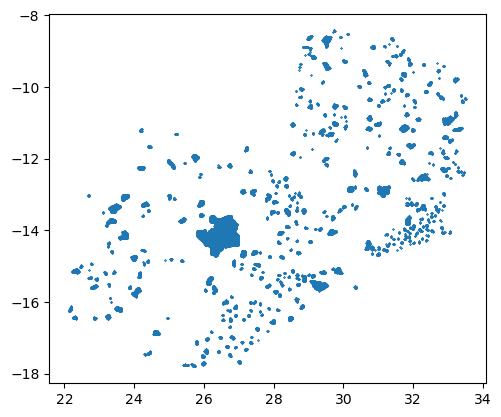

In [43]:
points.plot(markersize = 0.05)

### Impute missing values

Imputing "manually" by descending group levels imputes NA values in multiple "cascading" steps, decreasing the proportion of inoutated values with each step. First, the NA values are imputed at by both `year` and `district`, which should yield imputed values that most closely match the feature values that would be present in the data if there was no clouds obscuring the satellite images. Next, the remaining NA values that could not be imputed by both `year` and `district` are imputed by only `district`. Lastly, the remaining NA vlaues that could not be imputed by both `year` and `district` or by just `district` are imputed by `year` only. This option gives the user more control and transparency over how the imputation is executed.

Imputing using `scikit learn`'s simple imputer executes standard imputation, the details of which can be found in the `scikitlearn` documentation [here.](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html)

The imputation approach depends on the selection made at the top of this notebook for `impute_manual`.

In [44]:
# compute the number of cells in the features dataframe, based on the amount of rows (images), months, and feature columns
num_cells = len(features) * len(month_range) * num_features

In [45]:
class bcolors:
    BL = '\x1b[1;34m' #GREEN
    GR = '\x1b[1;36m' #GREEN
    YL = '\x1b[1;33m' #YELLOW
    RD = '\x1b[1;31m' #RED
    RESET = '\033[0m' #RESET COLOR

In [ ]:
%%time
if impute_manual:
    ln_ft = len(features)
    ln_na = len(features.dropna())
    print(f'Starting total row count: {bcolors.BL}{ln_ft}{bcolors.RESET}',
          f'\nPre-Impute NaN row count: {bcolors.RD}{ln_ft - ln_na}{bcolors.RESET}',
          f'\nPre-Impute NaN row %: {bcolors.RD}{((ln_ft - ln_na) / ln_ft)*100:.02f}{bcolors.RESET}',
          f'\nPre-Impute NaN cell %: {bcolors.RD}{(features.isna().sum().sum() / num_cells)*100:.02f}{bcolors.RESET}',
          f'\n\nStep 1: Filling NaN values by month, year, and district group average')
    features = (
        features
        .fillna(features
                .groupby(['year', 'district'], as_index=False)
                .transform('mean')
               )
    )
    ln_ft = len(features)
    ln_na = len(features.dropna())
    print(f'Post step 1 NaN row count: {bcolors.YL}{ln_ft - ln_na}{bcolors.RESET}',
          f'\nPost step 1 NaN row %: {bcolors.YL}{((ln_ft - ln_na) / ln_ft)*100:.02f}{bcolors.RESET}',
          f'\nPost step 1 NaN cell %: {bcolors.YL}{(features.isna().sum().sum() / num_cells)*100:.02f}{bcolors.RESET}',
          f'\n\nStep 2: Filling NaN values by month and district across group average')
    features = (
        features
        .fillna(features
                .groupby(['district'], as_index=False)
                .transform('mean')
               )
    )
    ln_ft = len(features)
    ln_na = len(features.dropna())
    print(f'Post step 2 NaN row count: {bcolors.GR}{ln_ft - ln_na}{bcolors.RESET}',
          f'\nPost step 2 NaN row %: {bcolors.GR}{((ln_ft - ln_na) / ln_ft)*100:.02f}{bcolors.RESET}',
          f'\nPost step 2 NaN cell %: {bcolors.GR}{(features.isna().sum().sum() / num_cells)*100:.02f}{bcolors.RESET}',
          f'\n\nStep 3: Drop remaining NaN values\n')
    features = features.dropna(axis=0)
    print(f'Ending total row count: {bcolors.BL}{len(features)}{bcolors.RESET}')
else:
    features = features.set_index(['year', 'district'])
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    imputer.fit_transform(features)
    features[:] = imputer.transform(features)
    features = features.reset_index()

### Save copy of processed features before sumarizing training features to district level

Duplicate the features dataframe at this stage so we can retain a copy of features at point resolution for all years available, which is `2013/2014/2016-2021`.

    - The start year is `2016` if the satellite selected is Sentinel 2 (due to the fact that Sentinel 2 launched in June of `2015`)
    - The start year is `2013` if the satellite selected is Landsat 8 and the month range selected was anything besides all months (due to the fact that Landsat 8 launched in February of `2013`)
    - The start year is `2014` if the satellite selected is Landsat 8 and the month range selected was all months
    
This duplicated dataframe we create in the following code is called `features_all_years`. The purpose for this dataframe comes into play after the model is trained; we will be able to plug in point-resolution features from _any and all_ years from this dataframe into the trained model and observe how the model predicts crop years across space and time. It would be interesting to plot these features for each year sequentially to show how the crop prediction landscape changes by year. These point-resolution features increase the spatial resolution of the ground-truth crop data we have for the years through 2018, because our ground-truth crop data is at a the coarser  district-resolution. Furthermore, these point-resolution features are the _only_ crop data we have for the years 2020-2021. The reason we lack data from 2019 is because the Zanbia Sattistics Agency has not yet released their Crop Forecast Survey data for that year. The reason we do not have data for 2020-2021 is because Covid-19 prevented any Crop Forecast Surveys from being conducted. 


After we create the dataframe `features_all_years`, we are free to further process the original features dataframe, `features`, in order to train the model with these features and their paired ground-truth crop yields. Processing this dataframe further requires us to subset the years to the start year through the years for which we have crop data: `2013/2014/2016-2019`. This dataframe is called `features_through_2019`. The reason we subset this dataframe is because we are training the model using _supervised_ machine learning, which means we are feeding it only features that have ground-truth crop data accosicated with them.

In [ ]:
features_all_years = features.copy()

# assign the geometry column to features_2014_2021 so it can serve 2 purposes:
# 1. plotting features sequentially by year
# 2. the entire dataframe can be fed into the model after the model is trained on only the summarized features for 2014-2018 and the associated crop data
features_all_years['geometry'] = points.geometry
# moving forward in the immediate sections, summarize the `features` dataframe to district level

### Subset the `features` dataframe to the years `2013/2014/2016-2019`

As discussed above, all feature data required the previous processing steps. However, the following code is not executed on _all_ features.
1. The `2013/2014-2019` (Landsat 8) or `2016-2019` (Sentinel 2) set of features is named `features_through_2019` so the name is agnostic to the selected satellite and month range.
2. The features in each row (point) in `features_through_2019` will be summarized to administrative boundary level (all rows (points) have already been assigned to the district in which they reside).
2. These summarized features in `features_through_2019` will then be joined with the district-resolution crop data. Next, we split these features into train and test sets, and then use them to train the model using ridge regression.
3. Lastly, apply the trained model to the larger, comprehensive feature set for `2013/2014-2021` (Landsat 8) or `2016-2021` (Sentinel 2), called `features_all_years`, which includes all years regardless if those years have ground truth crop data. 

After we train the model, recall that we are _most interested_ in generating crop predictions for the three years `2020-2021` because the model was not trained on these years at all, and it is an "out-of-bag sample" in machine learning terms. The following code splits the data correctly no matter which satellite was selected at the top of the notebook.

In [ ]:
# subset the features dataframe to just the years 2013/2014/2016-2019
# this will allow us to join these years to the crop data over space and time in the next section
features_through_2019 = features[features.year <= year_end_crops]

# check that subsetting years worked
print(features_through_2019["year"].unique())
# output should be 2016, 2017, 2018, 2019 for Sentinel 2
# output should be 2013/2014, 2015, 2016, 2017, 2018, 2019 for Landsat 8

### Summarise to administrative boundary level
Weighted by cropped area, or simple mean, depending on the selection at the top of this notebook for `weighted_avg`. 

In [ ]:
# check the order of the columns in the dataframe that will be summarized and then fed into the ridge regression in order to train the model
# we care about the order of columns specifically because in the following steps we assign only the feature columns to an object, so we need to know which 3 columns to omit by indexing
features_through_2019.columns

The output above show that the 3 columns that are _not_ features are the first 2 columns `year` and `district`, and the last column, `crop_perc`.

In [ ]:
# check the shape to the dataframe as a sanity check
features_through_2019.shape

The output above shows the number of rows and columns in the dataframe, respectively. Recall that the number of rows represents the number of points for which we have features, and the number of columns is all features for all months selected plus the columns `year`, `district`, and `crop_perc`. There are 13866 rows, meaning that is the amount of training points we have to feed into the model _before they are summarized to district level_, so this number will shrink after we summarize to district level. There are 12003 columns, which will not change after we summarize the features to district level. The number of columns that we include in the features object in the next chunk will be this number minus the 3 non-feature columns.

In [ ]:
# create object that contains only feature columns, rather than all columns that would include `district`, `year`, and `crop_perc`
# python index starts at 0, so here we specify to retain columns starting at 3 through every column besides the last column
# the columns we omit stay in the dataframe, because we assign the selected columns to an object, but the omitted columns are not included in the calculation in the next chunk
var_cols = features_through_2019.columns[2:-1].values.tolist()

# call the object `var_cols` to check that it only includes feature columns, but do not view it in list format because it is more readable not as a list 
features_through_2019.columns[2:-1]
# these are all the feature columns that will be fed into the `weighted_avg` calculation in the next chunk

In [ ]:
%%time
# execute the weighted average on the cropped area
# if the object `weighted_avg` was set to True at the top of the notebook, this calculation gives more weight (importance) to area in Zambia that has a high proportion of cropland
# this differs from the masking step that was executed earlier, because the masking step completely removed all land that was 0% cropland, and this step processes the land that is >1% cropland
if weighted_avg:
    features_summary = (
        features_through_2019
        .groupby(['year', 'district'], as_index=False)
        .apply(lambda x: pd.Series([sum(x[v] * x.crop_perc) / sum(x.crop_perc) for v in var_cols]))
    )
# if weighted_avg was set to FALSE at the beginning of the notebook, the weighted avergae is not executed
# instead, the features are simply summarized by district and year, which also occurred above if weighted_avg was set to TRUE
else:
    features_summary = features_through_2019.groupby(['district',"year"], as_index = False).mean()
# now that we have renamed our features object to `features_summary`, note that we use this object moving forward

Now that the features have been summarized to district and year, there are fewer rows. The dataframe we were working with before this step,  `features_through_2018`, had 13866 rows that represented points. Now we have 216 rows, as shown by the following output. Notice we still have all 12003 columns. 

In [ ]:
features_summary.shape

### Join crop data

Combine the crop data and features into 1 dataframe in order to train the model on this object in the next section. The crop data is at district-resolution, as is the feature data in the dataframe `features_summary`.

In [ ]:
# remind yourself of the object `crop_df` we created much earlier in the notebook when we read in the crop data in the section "Crop yield"
crop_df

This dataframe needs to undergo a little processing before we can join it to `features_summary`.
1. Firstly, we need to subset the years to just the years for which we have features. 
2. Next, we remove 2 districts. We do this because the district shapefile that we used to assign districts to the feature data does not include the districts Mafinga or Ikelenge. It is not uncommon for district boundaries to change slightly over time in sub-Saharan Africa. This was determined by examining the unique district values in both dataframes before executing the follwoing chunk.
3. Lastly, we reset the index so all 3 variables are columns.

In [ ]:
# take subset of crop dataframe so that it only includes the years for which we have feature data, through 2018
# this subsets the dataframe correctly no matter which satellite was selected
# COME BACK TO THIS PART TO DETEMRINE HOW TO HANDLE +1 
# delete: crop_through_2018 = crop_df[crop_df.year >= year_start]
# delete: crop_through_2018 = crop_df[crop_df.year >= year_start + 1]
# suggested change:
crop_through_2019 = crop_df[crop_df.year >= min(features_summary.year)]

# now the crop data starts in 2013, 2014 or 2016, depending on which satellite was selected and which month range was selected
# remove 2 districts because they are not present in one shapefile 
crop_through_2019 = crop_through_2019[~crop_through_2019.index.isin(['Mafinga', 'Ikelenge'])]
# reset index so all 3 variables are columns
crop_through_2019.reset_index(inplace = True)
# take a look at the crop dataframe as a sanity check that the processing steps were correct
# the `yield_mt` data is in units of metric tonnes per hectare of cropland planted
crop_through_2019
# if interested, please see more details about the crop data in our technical documentation for this project

Now remind yourself of the columns of the features dataframe so we know which column(s) we can use to join the dataframes:

In [ ]:
features_summary.columns

The columns we can join by are `district` and `year`.

In [ ]:
# join the crop data with the summarized feature data through 2019
features_summary = (
    features_summary
    .set_index(["district", "year"])
    .join(other = crop_through_2019.set_index(["district", "year"]))
    .reset_index())

features_summary.columns
# now that the data is joined, the column `yield_mt` is present in `features_summary`

Now that the summarized features are joined to the crop data, each row represents summarized features for a district for one year. For example, the top rows of this dataframe show the district Chadiza for several years, then the district switches to Chama, with a Chama row for each year, and so on all the way through the districts until the last one, Zambezi.

In [ ]:
features_summary

## Model

### Define `x`'s and `y`'s that will be a part of training the model

Since our independent variable is the features, these are the `x`'s. Our dependent variable is the crop yield in metric tonnes per hectare planted, so that will be the `y`'s.

In [ ]:
# this if-else statement is determined by the selection of True or False made at the top of the notebook for the object `weighted_avg`
if weighted_avg:
    drop_cols = ['district', 'year', 'yield_mt']
else:
# if the selection was False, we can drop the `crop_perc` columns because we will not use it moving forward
    drop_cols = ['district', 'year', 'yield_mt', "crop_perc"]
# note that this chunk does not actually execute the column dropping, it just defines the object that will determine which are dropped in the next chunk

In [ ]:
# define ALL x's (the features_summary data that will be fed into the model to train) by dropping the columns specified in the previous chunk
# if the `axis` argument was set to 0, this code would incorrectly drop rows instead of columns
x_all = features_summary.drop(drop_cols, axis = 1)

# log transform the `yield_mt` column because that was recommended by the client
y_all = np.log10(features_summary.yield_mt.to_numpy() + 1)

In [ ]:
# take a look at the first 10 values of the log transformed `yield_mt` array to get an idea of the scale of the crop yields we use to train the model
print(y_all[:10])

### Split into train and test sets

This step is executed right before training the model so we can train on 80% of the data and preserve 20% for testing.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    x_all, y_all, test_size = 0.2, random_state = 0
)

In [ ]:
print("Number of total points: ", len(x_all), "\n", 
      "Number of training points: ", len(x_train), "\n",
      "Number of testing points: ", len(x_test), sep = "")

### Train model using cross-validated ridge regression

Please see the documentation for the function that executes this regression [here.](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html)

In [ ]:
ridge_cv_random = RidgeCV(cv = 5, alphas = np.logspace(-8, 8, base = 10, num = 17))
ridge_cv_random.fit(x_train, y_train)

In [ ]:
print(f"Estimated regularization parameter: {ridge_cv_random.alpha_}")

### Validation set $R^2$ performance

In [ ]:
print(f"Validation R2 performance: {ridge_cv_random.best_score_:0.2f}")

### Train set

In [ ]:
y_pred = np.maximum(ridge_cv_random.predict(x_train), 0)
r2_train = r2_score(y_train, y_pred)

fig, ax = plt.subplots(ncols=1)
plt.scatter(y_pred, y_train, alpha=1, s=4)
plt.xlabel("Predicted", fontsize=15, x = .3)
plt.ylabel("Ground Truth", fontsize=15)
plt.suptitle(r"$\log_{10}(1 + Crop Yield)$", fontsize=20, y=1.02)
plt.title((f"Model applied to train data n = {len(x_train)}, R$^2$ = {r2_train:0.2f}"),
          fontsize=12, y=1.01)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

ax.axline([0, 0], [1, 1], c = "k")

plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)


# plt.savefig(f'images/{feature_file_name}_train_data.jpg', dpi=300)
plt.show()
plt.close()
# the model is plotted with a black 45 degree line that serves as a reference of what a perfect correlation would look like
# deviation of the line indicates that there is not a perfect correlation

In [ ]:
print(f"Training R^2 = {r2_train:0.2f}\nPearsons r = {pearsonr(y_pred, y_train)[0]:0.2f}") 

In [ ]:
# Pearson r^2
pearsonr(y_pred, y_train)[0] ** 2

In [ ]:
# alternative way to calculate Training R^2
ridge_cv_random.score(x_train, y_train)

### Test set

In [ ]:
y_pred = np.maximum(ridge_cv_random.predict(x_test), 0)
r2_test = r2_score(y_test, y_pred)

plt.figure()
plt.scatter(y_pred, y_test, alpha=1, s=4)
plt.xlabel("Predicted", fontsize=15)
plt.ylabel("Ground Truth", fontsize=15)
plt.suptitle(r"$\log_{10}(1 + Crop Yield)$", fontsize=20, y=1.02)
plt.title(f"Model applied to test data n = {len(x_test)}, R$^2$ = {r2_test:0.2f}",
          fontsize=12, y=1)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

ax.axline([0, 0], [.75, .75], c = "k")

plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)

# plt.savefig(f'images/{feature_file_name}_test_data.jpg', dpi=300)
plt.show()
plt.close()

In [ ]:
print(f"Testing set R^2 = {r2_test:0.2f}")
print(f"Testing set pearsons R = {pearsonr(y_pred, y_test)[0]:0.2f}")

Summary of both train and test data sets

In [ ]:
y_pred = np.maximum(ridge_cv_random.predict(x_all), 0)

fig, ax = plt.subplots(figsize=(7, 7))
ax.axline([0, 0], [.75, .75], c = "k")
plt.scatter(y_pred, y_all, alpha=.9, s=15)
plt.xlabel("Predicted", fontsize=15)
plt.ylabel("Observed", fontsize=15)
plt.text(
    0, .8, fontsize=15, fontweight="bold",
    s=f"R$^2$={r2_train:0.2f} - Train set",
)
plt.text(
    0, .75, fontsize=15, fontweight="bold",
    s=f"R$^2$={ridge_cv_random.best_score_:0.2f} - Validation set",
)
plt.text(
    0, .7, fontsize=15, fontweight="bold",
    s=f"R$^2$={r2_test:0.2f} - Test set",
)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)

# plt.savefig(f'images/{feature_file_name}_all_data.jpg', dpi=300)
plt.show()
plt.close()

### Use the trained model to predict crop yields over all years from 1km grid-cell resolution features 

Recall that after we executed imputation on all feature years in the dataframe `features`, we copied the dataframe and named it `features_all_years`. Now we can plug that into the model to visualize how our model performs over time.

In [ ]:
# recall the object we created earlier, before we split the features by year into those that would train the model 
# and those that would be fed into the trained model to predict crop yields
# in years for which we do not have crop data
features_all_years.head(3)

In the following chunk, we drop certain columns from `features_all_years` because we only need to feed the feature data into the model to generate predictions. Using the argument `axis = 1`, we specify that we are dropping columns rather than rows. 

In [ ]:
x_all = features_all_years.drop([
    'year', 
    'geometry',
    'district',
    'crop_perc'
], axis = 1)

In the following chunk, we execute the model on the features from the dataframe `features_all_years`. The crop yield predictions for each row populate a new column in the dataframe.

The model is run inside the `np.maximum()` function because if we run it without being wrapped inside function, some crop predictions are negative values, but we need them all to be positive because conceptually crop yields cannot be negative.

In [ ]:
features_all_years['yield_prediction'] = np.maximum(ridge_cv_random.predict(x_all), 0)

In [ ]:
# check out the dataframe with the new column of predictions
features_all_years.head(3)

The dataframe is already a geodataframe, so we do not have to convert it to one before mapping predictions. However, we do need to replace all the zero value crop percentage areas with `NA`. We do this by applying the `mask()` function. This function is similar to an if-else statement. If the value of the `crop_perc` is equal to 0, that value is replaced by the value of the second argument, which is `NA`. If the value of `crop_prec` is _not_ equal to zero, we retain the current value. The argument `inplace = True` executes this replacement in the same cell. 

In [ ]:
features_all_years['yield_prediction'].mask(features_all_years['crop_perc']==0, np.nan, inplace=True)

Recall that this dataframe has a geometry column, with latitude and longitude together. In order to map the predicted features, we separate this geometry column into separate `lon` and `lat` columns. 

In [ ]:
# extract the longitude and latitude from the geometry column, and make then into independent columns
features_all_years['lon'], features_all_years['lat'] = features_all_years.geometry.x, features_all_years.geometry.y

Plot the predicted features for each year:

In [ ]:
def scatter(x, y, c, **kwargs):
    plt.scatter(x, y, c=c, s = 1.25)
sns.color_palette("viridis", as_cmap=True)
g = sns.FacetGrid(
    features_all_years, 
    col="year", 
    col_wrap = 4, 
    height=5, 
    aspect=1
)
g.map(scatter, "lon", "lat", "yield_prediction")
g.set_axis_labels(r"Yield Prediction")
# save the figure and name the file so that it represents the model parameters that created the predictions
# plt.savefig(f'images/{feature_file_name}_all_predictions.jpg', dpi=300)

Plot the model's predicted features summarized to district level. In this visualization, we choose a specific year to examine rather than visualizing all years in one figure. Visualizing the the features summarized to district level is interesting because the crop data resolution provided by Zambia Statistics Agency is at the district level, and therefore it is easier to compare our model results to those ground-truth values when they are summarized to district level as well. Furthermore, our model's crop predictions for the years 2020 and 2021 might be more valuable when summarized to district level if Zambian governments, policy-makers, farmers, and researchers wish to use this data to determine crop imports, exports, and storage according to district summaries. 

In [ ]:
features_all_years_summary = (
    features_all_years
    .groupby(['district',"year"], as_index = False)['yield_prediction']
    .mean()
    .set_index('district')
)

In [ ]:
# join Zambia's shapefile to the summarized features to map the districts
# reset the index so it is a properly formatted dataframe
features_all_years_summary = features_all_years_summary.join(country_shp).reset_index()

Now that the geometries have been converted to districts from points, the geomatries are now polygons. There is still a row for each district for each year.

In order to change the year visualized, simply change the year in the following code and re-run the chunk.

In [ ]:
features_all_years_summary[features_all_years_summary.year == 2020].plot(column = "yield_prediction")

Plot a boxplot for each year to visualize the range and quantile distribution of each year's crop predictions, summarized to district level. This enables us to identify years with exceptional disparities between the predicted yields by district. It also allows us to identify years that have many outliers.

In [ ]:
plt.figure(figsize=(10, 5))
sns.boxplot(x="year", y="yield_prediction", data = features_all_years_summary)
plt.xlabel("Year", fontsize=15)
plt.ylabel("Predicted Yield", fontsize=15)

Visualize the total crop yield predictions by year. This bar chart shows the sum of all the district crop yields.

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(x="year", y="yield_prediction", data = features_all_years_summary, estimator = sum)

## Yield and Residual Plots

Create a dataframe of residuals called `residuals_df` from the `features_summary` dataframe. Note that we are _not_ using the predicted crop yields for _all_ years for these residuals, but rather the ground-truth crop yields for just the years through 2018.

The residuals give us an idea of the amount of uncertianty that is present in our model. By demeaning the residuals over space, we are able to remove the uncertainty over space and better determine our model performance over time and our uncertainty over time.

In [ ]:
x_all = features_summary.drop(drop_cols, axis = 1)

# create empty dataframe to then populate with columns
residual_df = pd.DataFrame()

residual_df["yield_mt"] = features_summary.yield_mt.to_numpy()
residual_df["log_yield"] = np.log10(features_summary.yield_mt.to_numpy() + 1)
residual_df["prediction"] = np.maximum(ridge_cv_random.predict(x_all), 0)
residual_df["residual"] = residual_df["log_yield"] - residual_df["prediction"]
residual_df["year"] = features_summary.year
residual_df["district"] = features_summary.district
# join the district geometries
residual_df = residual_df.join(country_shp, how = "left", on = "district")

# demean by location so we can analyze the data over time
residual_df["district_yield_mean"] = residual_df.groupby('district')['log_yield'].transform('mean')
residual_df["district_prediction_mean"] = residual_df.groupby('district')['prediction'].transform('mean')
residual_df["demean_yield"] = residual_df["log_yield"] - residual_df["district_yield_mean"]
residual_df["demean_prediction"] = residual_df["prediction"] - residual_df["district_prediction_mean"]
residual_gdf = geopandas.GeoDataFrame(residual_df)

residual_gdf.head(3)

Visualize the residuals for the ground truth crop yields through 2018 with a boxplot.

In [ ]:
plt.figure(figsize=(6, 5))
sns.boxplot(x="year", y="log_yield", data=residual_df)
plt.xlabel("Year", fontsize=15)
plt.ylabel("Log Yield", fontsize=15)

Visualize the residuals as a sum by year with a bar plot.

In [ ]:
plt.figure(figsize=(6, 5))
sns.barplot(x="year", y="log_yield", data=residual_df, estimator = sum)

Visualize the crop yield residuals by year as a histogram to determine how they are distributed.

In [ ]:
g = sns.FacetGrid(
    residual_gdf, 
    col="year", 
#     col_wrap = 3, 
    height=4, 
    aspect=1
)
g.map(sns.histplot, "yield_mt", bins = 20)
g.set_axis_labels("Yield (MT)")

Visualize the log-transformed crop yield residuals by year as a histogram to compare how they are distributed after the transformation.

In [ ]:
g = sns.FacetGrid(
    residual_gdf, 
    col="year", 
#     col_wrap = 3, 
    height=4, 
    aspect=1
)
g.map(sns.histplot, "log_yield", bins = 20)
g.set_axis_labels(r"$\log_{10}(1 + Crop Yield)$")

#### Crop prediction histogram

In [ ]:
g = sns.FacetGrid(
    residual_gdf, 
    col="year", 
#     col_wrap = 3, 
    height=4, 
    aspect=1
)
g.map(sns.histplot, "prediction", bins = 20)
g.set_axis_labels(r"Crop yield predictions")

#### Residual histogram

In [ ]:
g = sns.FacetGrid(
    residual_gdf, 
    col="year", 
#     col_wrap = 3, 
    height=4, 
    aspect=1
)
g.map(sns.histplot, "residual", bins = 20)
g.set_axis_labels(r"Residuals")

In [ ]:
residual_gdf.residual.min()

In [ ]:
residual_gdf.residual.max()

#### Log crop yield vs residuals

In [ ]:
g = sns.FacetGrid(
    residual_gdf, 
    col="year", 
#     col_wrap = 3, 
    height=4, 
    aspect=1
)
g.map(sns.scatterplot, "log_yield", "residual")
g.set_axis_labels(r"$\log_{10}(1 + Crop Yield)$")

#### District residuals 

In [ ]:
if satellite == 'landsat-8-c2-l2':
    fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))
    ax1 = (residual_gdf[residual_gdf.year == 2014]
           .plot(ax = ax1, column = "residual", legend = True, norm=colors.Normalize(vmin= -0.4, vmax=0.4), cmap = "BrBG")
           .set_title("2014 Residuals"))
    ax2 = (residual_gdf[residual_gdf.year == 2015]
           .plot(ax = ax2, column = "residual", legend = True, norm=colors.Normalize(vmin= -0.4, vmax=0.4), cmap = "BrBG")
           .set_title("2015 Residuals"))
else:
    pass
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
ax1 = (residual_gdf[residual_gdf.year == 2016]
       .plot(ax = ax1, column = "residual", legend = True, norm=colors.Normalize(vmin= -0.4, vmax=0.4), cmap = "BrBG")
       .set_title("2016 Residuals"))
ax2 = (residual_gdf[residual_gdf.year == 2017]
       .plot(ax = ax2, column = "residual", legend = True, norm=colors.Normalize(vmin= -0.4, vmax=0.4), cmap = "BrBG")
       .set_title("2017 Residuals"))
ax3 = (residual_gdf[residual_gdf.year == 2018]
       .plot(ax = ax3, column = "residual", legend = True, norm=colors.Normalize(vmin= -0.4, vmax=0.4), cmap = "BrBG")
       .set_title("2018 Residuals"))

caption = "A positive value is an underestimated prediction (the prediction is lower than the actual yield), a negative value is an over estimated prediction"
plt.figtext(0.5, 0.01, caption, wrap=True, horizontalalignment='center', fontsize=12)


#### Difference from the mean

In [ ]:
g = sns.FacetGrid(
    residual_gdf, 
    col="year", 
#     col_wrap = 3, 
    height=4, 
    aspect=1
)
g.map(sns.scatterplot, "demean_yield", "demean_prediction")
g.set_axis_labels('Difference from Yield Mean', 'Difference from Prediction Mean')

In [ ]:
fig, ax = plt.subplots(figsize= (6, 5))
ax.axline([-.2, -.2], [.2, .2], c = "k")
plt.scatter(residual_gdf.demean_yield, residual_gdf.demean_prediction)
plt.title("Demeaned truth and predictions by district")
plt.xlabel('Difference from Yield Mean')
plt.ylabel('Difference from Predictions Mean')
r_squared = r2_score(residual_gdf["demean_yield"], residual_gdf["demean_prediction"])
plt.text(
    -0.2,
    .18,
    s=f"Demeaned R$^2$ = {r_squared:0.2f}",
    fontsize=15,
    fontweight="bold",
)
plt.savefig(f'images/{feature_file_name}_demean.jpg', dpi=300)

In [ ]:
for yr in range(year_start+1, 2018):
    r_squared = r2_score(residual_gdf[residual_gdf.year == yr]["demean_yield"], residual_gdf[residual_gdf.year == yr]["demean_prediction"])
    pearson_r = pearsonr(residual_gdf[residual_gdf.year == yr]["demean_yield"], residual_gdf[residual_gdf.year == yr]["demean_prediction"])
    
    print(yr, f"    R^2: {r_squared:.2f}\n",
          f"Pearson's r: {pearson_r[0]:.2f}\n", 
          sep = "")
    
r_squared = r2_score(residual_gdf["demean_yield"], residual_gdf["demean_prediction"])
pearson_r = pearsonr(residual_gdf["demean_yield"], residual_gdf["demean_prediction"])
print(f"All     R^2: {r_squared:.2f}\n",
      f"Pearson's r: {pearson_r[0]:.2f}", sep = "")

In [ ]:
r2 = round(pearson_r[0] ** 2, 2)
r2

#### Join residuals to the features for _all_ years to visualize the residuals of the features before they were summarized to district level.

In [ ]:
complete_df = (
    features_all_years_summary
    .set_index(['district', 'year'])
    .join(residual_df
          .drop('geometry', axis = 1)
          .set_index(['district', 'year'])
         )
    .reset_index()
)

complete_df.head(3)

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 5))
tidy = complete_df.melt(id_vars='year').rename(columns=str.title)
tidy = tidy[tidy.Variable.isin(['yield_prediction', 'log_yield'])]
sns.barplot(x='Year', y='Value', hue='Variable', data=tidy, ax=ax1, ci = None)
sns.despine(fig)

h, l = ax1.get_legend_handles_labels()
ax1.legend(h, ['Predicted Yield', 'Observed Yield'],loc='lower left')

plt.savefig(f'images/{feature_file_name}_yield_pred.jpg', dpi=300)

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(x="year", y="yield_prediction", data=complete_df, estimator = sum)

### Congratulations on completing this analysis!